#### Need to install pycocotools

first:
conda install git
then:
pip3 install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

In [18]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from data_loader_ddr import get_loader 
from build_vocab_ddr import Vocabulary
from model import EncoderCNN, DecoderRNN
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import nltk

In [19]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
#os.getcwd()

In [21]:
#nltk.download('punkt')

# Build Vocabulary

In [43]:
!python build_vocab_ddr.py

0 159259
( 7692
4 46368
2 51961
8 43666
) 7693
6 45173
B 6774
A 3166
3 2873
1 2780
7 1590
D 5576
C 5519
9 1516
F 234
G 204
M 318
I 256
H 223
J 238
K 213
E 131
[ 821
] 823
L 96
{ 201
} 200
! 3293
5 6
Total vocabulary size: 11
Saved the vocabulary wrapper to './data/vocab_ddr.pkl'


C:\Users\brent\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


# Resize Images

In [44]:
#!python resize_ddr.py

# Define Args for Running in Notebook

In [57]:
class Args:
    model_path = 'ddrmodels/'
    crop_size = 224
    vocab_path = 'data/vocab_ddr.pkl'
    image_dir = 'data/resizedddr'
    caption_path = 'data/annotations/spectrogram_2.csv'
    log_step = 10
    save_step = 10
    embed_size = 300
    hidden_size = 300
    num_layers = 20
    num_epochs = 2
    batch_size = 16
    num_workers = 2
    learning_rate = 0.001
    
args=Args()

# Test Data Loaders

In [58]:
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build data loader
data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                         transform, args.batch_size,
                         shuffle=True, num_workers=args.num_workers) 


# for i, (images, captions, lengths) in enumerate(data_loader):

#     # Set mini-batch dataset
#     images = images.to(device)
#     captions = captions.to(device)
#     targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
#     print(images, captions, targets)


# if __name__ == '__main__':
# main(args)

In [59]:
vocab.idx2word

{0: '<pad>',
 1: '<start>',
 2: '<end>',
 3: '<unk>',
 4: '0',
 5: '(',
 6: '4',
 7: '2',
 8: '8',
 9: ')',
 10: '6'}

# Train the Model

In [60]:
def main(args):
    # Create model directory
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # Build data loader
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, args.batch_size,
                             shuffle=True, num_workers=args.num_workers) 

    # Build the models
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
    
    # Loss and optimizer
    #criterion = nn.CrossEntropyLoss(ignore_index=4) #Ignore 0's from the loss function
    criterion = nn.CrossEntropyLoss() #Ignore 0's from the loss function
    #params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    params = list(decoder.parameters()) + list(encoder.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)
    
    # Train the models
    total_step = len(data_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            #print(len(images), len(captions), len(targets))
            
            #Skip batches of 1 item
            if len(images) > 1:
                # Forward, backward and optimize
                features = encoder(images)
                outputs = decoder(features, captions, lengths)
                loss = criterion(outputs, targets)
                decoder.zero_grad()
                encoder.zero_grad()
                loss.backward()
                optimizer.step()

                # Print log info
                if i % args.log_step == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                          .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
                
            # Save the model checkpoints
            if (i+1) % args.save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


if __name__ == '__main__':
    main(args)

Epoch [0/2], Step [0/47], Loss: 2.3949, Perplexity: 10.9675
Epoch [0/2], Step [10/47], Loss: 1.8310, Perplexity: 6.2399
Epoch [0/2], Step [20/47], Loss: 1.7506, Perplexity: 5.7583
Epoch [0/2], Step [30/47], Loss: 1.7643, Perplexity: 5.8373
Epoch [0/2], Step [40/47], Loss: 1.7250, Perplexity: 5.6126
Epoch [1/2], Step [0/47], Loss: 1.8342, Perplexity: 6.2604
Epoch [1/2], Step [10/47], Loss: 1.7775, Perplexity: 5.9152
Epoch [1/2], Step [20/47], Loss: 1.7514, Perplexity: 5.7628
Epoch [1/2], Step [30/47], Loss: 1.8004, Perplexity: 6.0520
Epoch [1/2], Step [40/47], Loss: 1.7679, Perplexity: 5.8583


# Test Model

In [61]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab_ddr import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


In [64]:
class Args:
    image = 'C:/Users/brent/Desktop/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/resizedddr/Across the nightmare_1.png'
    encoder_path = 'ddrmodels/encoder-1-10.ckpt'
    decoder_path = 'ddrmodels/decoder-1-10.ckpt'
    vocab_path = 'data/vocab_ddr.pkl'
    embed_size = 300
    hidden_size = 300
    num_layers = 20

args=Args()

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

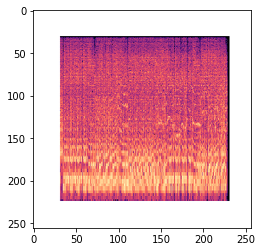

In [65]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    print(sampled_ids)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))
    
if __name__ == '__main__':

    main(args)